<a href="https://colab.research.google.com/github/meghutch/Breast-Cancer-Classification-Clinical-Genomic/blob/master/Neural_Networks_Clinical_Genetic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Clinical Outcomes of Breast Cancer Patients**

## **Analysis of Clinical Outcomes and Gene Expression**

**Author:** Meg Hutch

**Date:** December 6, 2019

**Objective:** We will examine models using just clinical data and then we will resassess using combined clinical + genomioc data to predict patient surivival greater than 10 years.

Unlike the **Neural_Network_Clinical_Outcomes** analysis, this will use the patients in the merged_expression.txt that were processed.

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [2]:
# Connect Colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## Import Data
# Clinical Data
bc_data = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Data/data_clinical_patient.csv')
# Gene Expression Data 
gene_data = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Data/merged_expression.txt', sep=',')

# **Pre-Process Data**

**Clinical Data**




Rows 0-3 contain definitions of data and data types. We can remove these

In [0]:
bc_data = bc_data.iloc[4:]

Convert first row to header name

In [0]:
# Convert first row to header name
bc_data = bc_data.rename(columns=bc_data.iloc[0]).drop(bc_data.index[0])

Convert column names to lowercase

In [0]:
# Convert column names to lowercase
bc_data.columns = map(str.lower, bc_data.columns)

In the project directions, it says we can treat "Died of Other Causes" as living. Thus, change the category title as such.

In [0]:
bc_data['vital_status'] = bc_data['vital_status'].replace({'Living': 'Living', 'Died of Disease': 'Died of Disease', 'Died of Other Causes': 'Living'})

Remove any incomplete cases

In [0]:
bc_data = bc_data.dropna()

I'm not sure if sometimes there are missing values just because something wasn't performed, in the case of surgery perhaps? Either way...I'm just going to remove missing values -- May be good to ask about this though

**One Hot Encoding**

Because some categorical features have multiple categories, we need to use one-hot-encoding to represent these varaibles in the dataset. Just creating numeric levels won't always make sense in the case of features like caludin_subtype which are genomic classifications

For features that are binary - we will not need to seperate these into 2 variables - does not make sense!

In [9]:
# Determine which variables we want to one-hot-encode
print('Cellularity:', bc_data['cellularity'].unique())
print('Chemotherapy:',bc_data['chemotherapy'].unique()) # binary
print('Er_ihc:',bc_data['er_ihc'].unique()) # binary 
print('Her2_snp6:',bc_data['her2_snp6'].unique())
print('Hormone Therapy:',bc_data['hormone_therapy'].unique()) # binary
print('Inferred_menopausal_state:',bc_data['inferred_menopausal_state'].unique()) # binary
print('Interclust:',bc_data['intclust'].unique())
print('Claudin_Subtype:',bc_data['claudin_subtype'].unique())
print('Threegene:',bc_data['threegene'].unique())
print('Laterality:',bc_data['laterality'].unique()) # binary
print('Radio_Therapy:',bc_data['radio_therapy'].unique()) # bianry
print('Histological_Subtype:',bc_data['histological_subtype'].unique())
print('Breast_Surgery:',bc_data['breast_surgery'].unique())
print('Vital_status:',bc_data['vital_status'].unique())

Cellularity: ['High' 'Moderate' 'Low']
Chemotherapy: ['NO' 'YES']
Er_ihc: ['Positve' 'Negative']
Her2_snp6: ['NEUTRAL' 'GAIN' 'LOSS' 'UNDEF']
Hormone Therapy: ['YES' 'NO']
Inferred_menopausal_state: ['Pre' 'Post']
Interclust: ['4ER+' '9' '7' '3' '8' '10' '5' '6' '1' '2' '4ER-']
Claudin_Subtype: ['LumA' 'LumB' 'Her2' 'Normal' 'Basal' 'claudin-low' 'NC']
Threegene: ['ER+/HER2- High Prolif' 'ER+/HER2- Low Prolif' 'ER-/HER2-' 'HER2+']
Laterality: ['Right' 'Left']
Radio_Therapy: ['YES' 'NO']
Histological_Subtype: ['Ductal/NST' 'Mixed' 'Lobular' 'Tubular/ cribriform' 'Mucinous'
 'Medullary' 'Other']
Breast_Surgery: ['BREAST CONSERVING' 'MASTECTOMY']
Vital_status: ['Living' 'Died of Disease']


In [0]:
# Convert patient_ids to row names 
bc_data = bc_data.set_index(bc_data.patient_id)

In [0]:
# Create dataframe with the unchanged varaibles - this will contain numeric variables
bc_data1 = bc_data[['lymph_nodes_examined_positive', 'npi', 'age_at_diagnosis', 'os_months', 'vital_status', 'chemotherapy', 'er_ihc', 'hormone_therapy', 'inferred_menopausal_state', 'radio_therapy', 'laterality']]

## Seperate the dataframes into the variables that we will want to reshape - we can then recombine anything that has more than 2 levels
# Cellularity
cell_df = bc_data[['cellularity']]
cell_df = pd.get_dummies(cell_df,prefix=['cellularity'])

# Her2_snp6
her2_df = bc_data[['her2_snp6']]
her2_df = pd.get_dummies(her2_df,prefix=['her2'])

# Interclust
intclust_df = bc_data[['intclust']]
intclust_df = pd.get_dummies(intclust_df,prefix=['intclust'])

# Claduin Subtype
cs_df = bc_data[['claudin_subtype']]
cs_df = pd.get_dummies(cs_df,prefix=['claudin_subtype'])

# Threegene
three_df = bc_data[['threegene']]
three_df = pd.get_dummies(three_df,prefix=['threegene'])

# Histological_Subtype
hist_df = bc_data[['histological_subtype']]
hist_df = pd.get_dummies(hist_df,prefix=['hist'])

# Breast Surgery
surg_df = bc_data[['breast_surgery']]
surg_df = pd.get_dummies(surg_df,prefix=['breast_surgery'])

# We want to convert row index (patient_id) to the first column for all of the above datasets
bc_data1.reset_index(level=0, inplace=True)
cell_df.reset_index(level=0, inplace=True)
her2_df.reset_index(level=0, inplace=True)
intclust_df.reset_index(level=0, inplace=True)
cs_df.reset_index(level=0, inplace=True)
three_df.reset_index(level=0, inplace=True)
hist_df.reset_index(level=0, inplace=True)
surg_df.reset_index(level=0, inplace=True)

# Merge all data 
bc_data = pd.merge(bc_data1, cell_df, how="left", on="patient_id")
bc_data = pd.merge(bc_data, her2_df, how="left", on="patient_id")
bc_data = pd.merge(bc_data, intclust_df, how="left", on="patient_id")
bc_data = pd.merge(bc_data, cs_df, how="left", on="patient_id")
bc_data = pd.merge(bc_data, three_df, how="left", on="patient_id")
bc_data = pd.merge(bc_data, hist_df, how="left", on="patient_id")
bc_data = pd.merge(bc_data, surg_df, how="left", on="patient_id")

Create dummy variables for Vital Status - Our Label and the other binary variables

In [0]:
bc_data['vital_status'] = bc_data.vital_status.map({'Living': 0, 'Died of Disease': 1})
bc_data['chemotherapy'] = bc_data.chemotherapy.map({'NO': 0, 'YES': 1})
bc_data['er_ihc'] = bc_data.er_ihc.map({'Negative': 0, 'Positve': 1}) # careful with the positive spelling error in the dataset
bc_data['hormone_therapy'] = bc_data.hormone_therapy.map({'NO': 0, 'YES': 1})
bc_data['inferred_menopausal_state'] = bc_data.inferred_menopausal_state.map({'Pre': 0, 'Post': 1})
bc_data['laterality'] = bc_data.laterality.map({'Left': 0, 'Right': 1})
bc_data['radio_therapy'] = bc_data.radio_therapy.map({'NO': 0, 'YES': 1})

Covert numeric varaibles as such, right now they are all non-null objects

In [0]:
# convert first column to row index
bc_data = bc_data.set_index('patient_id')

# convert column object type to float for all columns
bc_data = bc_data.astype(np.float32)

# convert the row index back to the first column
bc_data.reset_index(level=0, inplace=True)

**Gene Expression Data**

Rename patient ID column

In [0]:
gene_data.rename(columns={'Unnamed: 0':'patient_id'}, inplace=True)

Remove redundant columns that also appear in the bc_data - EVENT indicates 5 year survival from the processing code

In [0]:
gene_data = gene_data.drop(columns=["EVENT", "OS_MONTHS", "FIVE_YEAR"])

Remove genes if there are missing values.

There are so many gene expression variables that I will not exclude patients if they are missing genetic data! Suprisingly, this only removes 6 genes which doesn't seem like it would make a big deal.

In [0]:
# how many genes (columns) are complete cases?
gene_data = gene_data.dropna(axis = 1) #axis = 1, represents dropping columns with any missing values

**Merge Clinical and Gean Data**

In [0]:
clinical_gene = pd.merge(bc_data, gene_data, how="left", on="patient_id")

# **Examine Patient Outcomes**

Assess the number of patients maintained in our final datasets and their outcomes

vital_status
0.0    1034
1.0     485
dtype: int64
Total Number of Patients: 1519
Percent Living: 0.68
Percent Died of Disease: 0.32


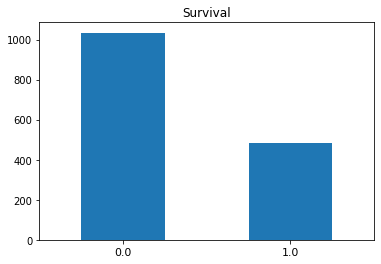

In [18]:
plt_out = clinical_gene.vital_status.value_counts().plot(kind="bar")
plt_out.tick_params(axis="x", labelsize=11, labelrotation= -360)
plt_out.set_title("Survival")

# Calculate Percents
count_outcomes = clinical_gene.groupby(['vital_status']).size()
print(count_outcomes)

print('Total Number of Patients:', len(clinical_gene.index))
print('Percent Living: {:.2f}'.format(count_outcomes[0]/len(clinical_gene.index)))
print('Percent Died of Disease: {:.2f}'.format(count_outcomes[1]/len(clinical_gene.index)))

After removing patients with missing clinical values, our dataset reduced to 
1,519 patients with 49 clinical variables (after one hot encoding) and mRNA expression for 24,368 genes. 

485 (32% of patients died from breast cancer) vs 1,034 (68%) of patients who surived. 


# **Assess the number of patients who surivived > 10 years**

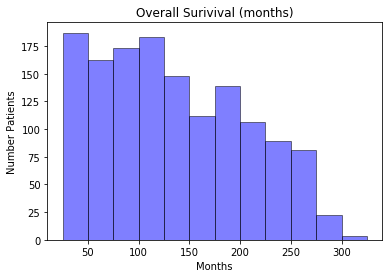

In [19]:
# examine patients who survived > 10 years
years10 = clinical_gene[clinical_gene['os_months'] >= 120]
os = clinical_gene['os_months']

# Define bins
bin_edges = [25,50,75,100,125,150,175,200,225,250,275,300,325]

plt.hist(os,
         bin_edges,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)

plt.xlabel('Months')
plt.ylabel('Number Patients')
plt.title('Overall Surivival (months)')

plt.show()

In [20]:
# Calculate Percents
count_outcomes = years10.groupby(['vital_status']).size()
print(count_outcomes)

print('Total Number of Patients:', len(years10.index))
print('Percent Living: {:.2f}'.format(count_outcomes[0]/len(years10.index)))
print('Percent Died of Disease: {:.2f}'.format(count_outcomes[1]/len(years10.index)))

vital_status
0.0    640
1.0     95
dtype: int64
Total Number of Patients: 735
Percent Living: 0.87
Percent Died of Disease: 0.13


The number of patients who are still living vs those deceased at 10 years is very unbalanced (87 vs 13% respectively). For this reason, I will continue to see whether my model can just predict survival status for patients.

# **Prinicipal Component Analysis**

**What is a Pricipal Component?**

Principal componenets have both direction and magnitude. The direction represents across which principal axes the data is mostly spread out or has the most variance and the magnitude signifies the amount of varaince that Principal Component captures of the data when projected onto that axis. 

The principal components are a straight line, and the first principal component holds the most variance in the data. Each subsequent prinicpal component is orthogonal to the last and has a lesser variance .

Correlated features contribute to the same principal component, thereby reducing the original data features into uncorrelated prinicpal components; each representing a different set of correlated features with differents of variation.

Each principal component represents a percentage of total variation captured from the data

**Reference:** https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python

Create a dataset just containing gene expression

In [0]:
# remove patient_id number from the list
gene_list = gene_data.drop(columns=["patient_id"])
gene_list = list(gene_list.columns.values) 
genes = clinical_gene[gene_list]

Create a dataset containing the target variables

In [0]:
# Subset only the Event - whether they lived (0) or died (1) from Breast Cancer
labels = clinical_gene.vital_status

# Create a list of row names
patients = list(clinical_gene.patient_id)

# Convert labels into a dataframe and indicate patients as the index
labels = pd.DataFrame(labels)
labels.index = patients

**1) Standardize the Data**

Must scale features in your data before applying PCA. **StandardScaler** helps standardize features onto unit scale (mean = 0 and standard deviation = 1). Thus, each value in the dataset will have the sample mean value subtracted and then divided by the standard deviation of the whole dataset. 


In [0]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

# Stanardize/Scale the data
x = StandardScaler().fit_transform(genes)

**Let's check whether the normalized data has a mean of zero and a standard deviation of 1**

In [24]:
np.mean(x), np.std(x)

(-2.1440133607904242e-17, 0.9999999999999993)

**Convert the normalized features into tabular format**

In [0]:
# Create list of column names
features = list(genes.columns.values) 

# Create data frame of newly normalized data - use patients IDs as the index 
x = pd.DataFrame(x, columns = features, index = patients)

**2) Determine Prinicpal Components**

Reference: https://stackoverflow.com/questions/42167907/understanding-scikitlearn-pca-transform-function-in-python

**pca.fit** allows PCA function to compute vectors that you can project your data onto in order to reduce the dimension of your data. 

**pca.transform** actually performs the projection. It projects each row of data into the vector space that was learned when fit was called.

from sklearn: **fit_transform**: Fit the model with X and apply the dimensionality reduction on X

In [26]:
# Define pca function
pca = PCA()

# Fit to the scaled/standardized data - then use transform to prokect into the new vector space learned by fit
principalComponents = pca.fit_transform(x)

# Generate a list of column names with the number for each prinicpal component 
col_names = [f'pc{i}' for i in range(1, 1520)] # there are 1519 samples - so we want to have range of 1 less than 1894 column names 

# Add column names to the principal component dataset 
principalDf = pd.DataFrame(principalComponents, columns = col_names, index = patients)
principalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,...,pc1480,pc1481,pc1482,pc1483,pc1484,pc1485,pc1486,pc1487,pc1488,pc1489,pc1490,pc1491,pc1492,pc1493,pc1494,pc1495,pc1496,pc1497,pc1498,pc1499,pc1500,pc1501,pc1502,pc1503,pc1504,pc1505,pc1506,pc1507,pc1508,pc1509,pc1510,pc1511,pc1512,pc1513,pc1514,pc1515,pc1516,pc1517,pc1518,pc1519
MB-0002,3.696282,-35.520444,-18.813925,1.425125,-11.277186,-12.822790,4.251192,-13.187488,-17.484249,11.620502,-15.428377,-5.990460,-29.259997,4.524617,3.793844,-7.150132,-12.587557,-37.377278,3.419039,26.264708,6.044982,-2.502963,1.401320,5.127579,-0.554830,5.563588,26.515756,3.069561,1.625547,-8.056935,22.297868,-11.136432,-3.898825,8.608120,15.322118,0.631834,24.200760,-4.407630,7.801561,-1.820877,...,-0.851903,-0.820321,-1.642542,-0.714742,-0.083163,-0.117520,0.446018,0.123201,-0.286876,0.862906,-0.740857,-0.638325,0.237807,-0.426543,1.113707,-0.483813,-0.404465,1.784340,0.393543,1.028003,-1.807742,1.267285,-2.133198,1.828599,-1.028531,1.017656,0.714164,0.324745,-0.115166,0.885927,2.199292,0.104009,-1.982049,-2.338708,-2.384222,0.130091,-0.962951,0.067313,-0.530014,3.226540e-15
MB-0008,-15.971143,-15.432191,-32.061045,-29.377546,-8.856750,16.612036,4.018346,-9.285566,-24.787766,-14.310316,-7.081939,-6.554999,-17.514326,12.673051,-10.707682,25.228763,0.435692,17.426256,-12.483955,1.874893,3.739397,-5.517330,-3.544084,-2.838839,-7.951403,-3.017424,26.522082,2.473416,1.399002,7.772540,-7.146870,-1.874910,26.551375,0.636265,-10.068891,9.494622,2.448461,-0.074939,2.973074,0.973043,...,-1.003014,0.211598,-0.573605,0.213198,-0.736603,0.827175,-1.081762,-0.253595,0.453540,-0.855541,-0.624416,-0.316994,0.172783,0.679761,-1.698007,1.912439,-0.959564,-1.278216,-0.443109,-0.593039,-1.367058,-0.716466,0.761005,1.036470,0.400830,0.588748,0.338256,1.608587,-1.796271,1.499539,2.822634,-0.182661,0.591917,4.032921,-0.171979,0.819953,1.105986,0.073620,0.849012,3.226540e-15
MB-0010,-17.454315,-21.192113,-16.013777,-7.492020,-17.781708,1.319311,4.626225,-36.678655,11.585110,-7.570376,19.811831,2.021583,4.881035,21.767445,-18.117848,-2.266797,-3.254472,-10.264998,-0.934028,-6.740692,-17.375263,-3.659842,-8.297658,6.420469,-0.993854,-8.072056,12.528807,-1.977940,0.149557,4.161107,-1.021197,10.186300,15.009833,-4.688344,-2.201153,1.599327,4.277693,-6.324380,8.316996,-4.912895,...,-0.678998,-0.223220,-0.167057,1.811523,-2.783100,2.144538,1.030696,0.488569,-0.316220,-0.024111,2.836332,-0.221322,-1.665299,-4.039378,3.307648,-1.033663,2.196228,1.300160,0.706553,0.293393,-1.965430,0.923175,1.627735,1.087859,0.504541,0.430675,0.872859,2.553531,-1.797532,-0.134177,-2.068498,5.143472,0.364079,0.351346,0.104836,-0.218196,0.175651,-1.284981,-1.062827,3.226540e-15
MB-0028,9.403215,-31.463949,-55.388704,-13.005234,11.937277,2.109379,22.726782,-1.859580,-4.650795,19.247580,33.419527,-8.320536,-9.179945,18.181183,11.843317,-5.115540,13.371169,10.410103,-15.389495,8.911308,-5.011614,8.180363,-0.863175,-1.473165,-16.251194,15.238271,-4.195064,8.499034,-5.676389,21.660309,-12.684467,-1.505352,-4.765341,-21.259345,-15.513800,-6.844603,-7.498684,16.295027,-5.931322,2.460076,...,-0.979506,0.235224,0.336212,0.218131,-0.519864,-0.571283,-1.254231,0.013132,-0.976211,-0.670816,-0.465293,0.641230,0.835912,-0.880166,0.590890,-0.494788,-0.051104,-1.686358,1.410132,-0.383044,-0.843910,0.601312,0.326957,-0.557102,1.792193,0.474294,0.468909,0.842941,-0.043868,0.079649,0.806323,0.231925,0.982790,-0.340688,3.044589,0.458794,-0.848811,-1.793592,0.049293,3.226540e-15
MB-0035,31.050602,-19.567061,-34.221343,2.309418,4.511127,-11.072959,24.240261,-10.302817,76.885148,12.591329,-16.085720,-39.863072,0.742399,17.884162,2.928844,6.740508,0.200073,-7.967774,-2.348785,14.305014,-13.524745,25.335851,3.131419,9.922605,0.675627,18.532697,26.519733,-26.763888,9.976703,-0.359545,-7.667654,-0.970275,12.245801,-6.540787,-3.143

**3) Determine # of Components and Variance**

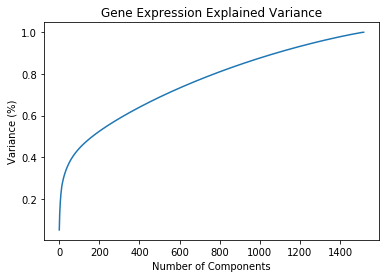

In [27]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Gene Expression Explained Variance')
plt.show()

The plot tells us that with ~1200 components we can capture 90% of the data. 

**Alternative method - Pre-selecting % of variance**

**Fit PCA to the data**

In [0]:
pca = PCA(0.9)
x2 = pca.fit_transform(x)

In [29]:
x2 = pd.DataFrame(data = x2)
x2 #this is the 1306 principal components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081
0,3.696282,-35.520444,-18.813925,1.425125,-11.277186,-12.822790,4.251192,-13.187488,-17.484249,11.620502,-15.428377,-5.990460,-29.259997,4.524617,3.793844,-7.150132,-12.587557,-37.377278,3.419039,26.264708,6.044982,-2.502963,1.401320,5.127579,-0.554830,5.563588,26.515756,3.069561,1.625547,-8.056935,22.297868,-11.136432,-3.898825,8.608120,15.322118,0.631834,24.200760,-4.407630,7.801561,-1.820877,...,1.519751,0.618311,-0.753857,-0.166051,0.120901,2.060494,-1.910674,-1.223022,2.986752,-1.503869,4.193182,2.097600,-2.074204,-2.180381,1.822595,1.106352,1.498331,0.006544,-0.596466,-1.034001,-2.691159,1.651816,-5.199850,-1.444879,-0.683766,1.363813,1.906447,0.160721,2.154376,-0.252365,-2.153099,-2.041484,-1.523603,1.165630,3.849985,0.830595,2.296211,-0.587605,1.104186,-0.681851
1,-15.971143,-15.432191,-32.061045,-29.377546,-8.856750,16.612036,4.018346,-9.285566,-24.787766,-14.310316,-7.081939,-6.554999,-17.514326,12.673051,-10.707682,25.228763,0.435692,17.426256,-12.483955,1.874893,3.739397,-5.517330,-3.544084,-2.838839,-7.951403,-3.017424,26.522082,2.473416,1.399002,7.772540,-7.146870,-1.874910,26.551375,0.636265,-10.068891,9.494622,2.448461,-0.074939,2.973074,0.973043,...,1.712946,0.459514,-1.154029,1.362965,-0.292343,1.711341,-3.314600,1.186201,-0.761270,1.967775,-1.711119,-1.152581,-1.799869,5.081633,0.909640,2.573330,-0.717697,2.396999,-1.245896,1.273799,-4.674970,1.203149,-1.520096,2.805260,-2.638399,-2.448532,3.794638,0.097845,-1.164509,-0.471169,1.377405,-0.853287,1.338591,-0.357237,-0.633683,-0.800436,0.810011,1.340168,-0.798210,-1.223037
2,-17.454315,-21.192113,-16.013777,-7.492020,-17.781708,1.319311,4.626225,-36.678655,11.585110,-7.570376,19.811831,2.021583,4.881035,21.767445,-18.117848,-2.266797,-3.254472,-10.264998,-0.934028,-6.740692,-17.375263,-3.659842,-8.297658,6.420469,-0.993854,-8.072056,12.528807,-1.977940,0.149557,4.161107,-1.021197,10.186300,15.009833,-4.688344,-2.201153,1.599327,4.277693,-6.324380,8.316996,-4.912895,...,-1.223901,-2.106331,-0.760177,4.843342,1.107638,-3.017967,-4.648905,3.048092,3.027965,1.616979,1.536353,0.178778,-6.406843,-3.523737,-7.151367,2.861658,-0.710840,0.887883,2.172923,-3.507742,0.220902,6.292423,3.639012,-1.003250,-6.437326,-5.065095,3.611600,-5.531053,3.632939,2.509875,0.962723,-0.661134,3.081940,0.892814,5.178428,3.467530,-2.803851,0.724807,0.088289,-0.697837
3,9.403215,-31.463949,-55.388704,-13.005234,11.937277,2.109379,22.726782,-1.859580,-4.650795,19.247580,33.419527,-8.320536,-9.179945,18.181183,11.843317,-5.115540,13.371169,10.410103,-15.389495,8.911308,-5.011614,8.180363,-0.863175,-1.473165,-16.251194,15.238271,-4.195064,8.499034,-5.676389,21.660309,-12.684467,-1.505352,-4.765341,-21.259345,-15.513800,-6.844603,-7.498684,16.295027,-5.931322,2.460076,...,-0.092010,1.288850,-0.771033,-0.124556,2.146973,-0.100798,0.769674,-0.516486,0.006709,-0.375824,-0.409659,2.292354,2.192934,1.570428,-2.199516,1.518836,-0.359485,1.144210,-1.209053,-1.217388,-0.313915,0.477952,1.541564,-3.130664,1.898384,0.805003,0.169660,1.693436,0.512796,-1.919766,2.544370,1.500939,-0.416430,-1.754322,3.016699,1.359719,-1.948353,2.346100,-1.001102,-0.767950
4,31.050602,-19.567061,-34.221343,2.309418,4.511127,-11.072959,24.240261,-10.302817,76.885148,12.591329,-16.085720,-39.863072,0.742399,17.884162,2.928844,6.740508,0.200073,-7.967774,-2.348785,14.305014,-13.524745,25.335851,3.131419,9.922605,0.675627,18.532697,26.519733,-26.763888,9.976703,-0.359545,-7.667654,-0.970275,12.245801,-6.540787,-3.143797,-11.420626,14.281943,-7.947586,-9.617343,4.053053,...,-3.589104,1.847147,-0.733278,-0.481472,-0.918108,-0.539586,0.339071,-1.332511,1.841690,0.360389,0.112321,-0.591697,1.279476,0.924937,2.928568,1.137

**Determine the exact number of n_components needed to capture 0.9 variance**

In [30]:
pca.n_components_

1082

This function indicates that 1082 is the number of principal components needed to capture 90% of the variation which is what I had estimated from the above plot.

**Scree Plot**

View which principal components contribute most to the variance 

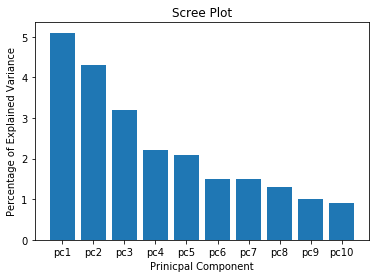

In [31]:
# remove PC from 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var = per_var[:10] #top 10 PC - this number is chosen just so that we can more easily view the plot
labels = col_names[:10]

plt.bar(x=range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Prinicpal Component')
plt.title('Scree Plot')
plt.show()

**Table with % Variance for the 1082 PCs making up 90% of the variance**

In [32]:
per_var_all = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var_all.shape # this shows the % variance explained for each component

# convert to dataframe
per_var_all = pd.DataFrame(per_var_all)

# add prinicipal component labels
per_var_all.index = col_names[:1082]

# rename column 0
cols = {'% Variance'}
per_var_all.columns = cols

# create a rolling calculation of the variance 
per_var_all['CumulativeVariance'] = per_var_all['% Variance'].cumsum()
print(per_var_all)

# save to csv 
per_var_all.to_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Processed_Data/component_variance_chart_90_1082.txt')

        % Variance  CumulativeVariance
pc1            5.1                 5.1
pc2            4.3                 9.4
pc3            3.2                12.6
pc4            2.2                14.8
pc5            2.1                16.9
...            ...                 ...
pc1078         0.0                75.1
pc1079         0.0                75.1
pc1080         0.0                75.1
pc1081         0.0                75.1
pc1082         0.0                75.1

[1082 rows x 2 columns]


**Draw PCA Plot**

With the two primary principal components

References: 

https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

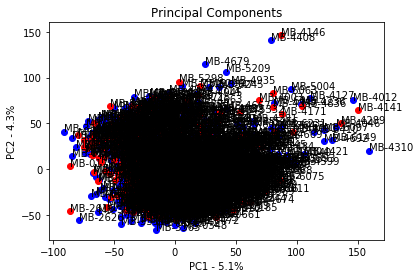

In [33]:
# Can use the function below with .sample to select a subset of PC components, making it more readible
principalDf_samp = principalDf.sample(n = 500) # will need to change the dataframe principalDf below to prinicpalDf_samp if I use this function

#plt.scatter(principalDf.pc1, principalDf.pc2)
plt.title('Principal Components')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

# Replace Labels
clinical_gene = clinical_gene.set_index(clinical_gene.patient_id)
clinical_gene['vital_status'].replace(0, 'Lived',inplace=True)
clinical_gene['vital_status'].replace(1, 'Died',inplace=True)

# Create labels for the targets to be used to color the graphs
targets = ['Lived', 'Died']
colors = ['b', 'r']

for target, color in zip(targets, colors):
    indicesToKeep = clinical_gene['vital_status'] == target
    plt.scatter(principalDf.loc[indicesToKeep, 'pc1'],
                principalDf.loc[indicesToKeep, 'pc2'], c = color)

# The labeled numbers are the indiviudal patients samples
for sample in principalDf.index:
  plt.annotate(sample, (principalDf.pc1.loc[sample], principalDf.pc2.loc[sample])) # my impression is that sample just indicates each row

# Subset
#sample_50 = principalDf.sample(n = 50)

# This plot is interesting -- it looks like it's creating random samples, but still impossing it on the main graph because we are indeicating pc1 and pc2 still which all samples would be under
#for sample in sample_50.index:
#  plt.annotate(sample, (sample_50.pc1.loc[sample], sample_50.pc2.loc[sample]))
#print(sample_50)

#print(principalDf.sample) -- I believe sample is returning just all of the row labels -- hard to read though which is why I was trying to subset
#print(principalDf.sample(n = 50))

**Determine Relevant Genes**

Get the name of the top 10 genes that contribute most to pc1. The following code looks at the components of each pca - which is also called the loading scores. Sorting by the absolute value, allows us to identify which genes, in either the negative or positive direction, had the most infleunce on each prinicipal component.



References: 

https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components

https://www.youtube.com/watch?v=FgakZw6K1QQ

In [34]:
## first, get the loading scores
loading_scores = pd.Series(pca.components_[0], index=features)

## now sort the loading scores based on their magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
 
# get the names of the top 10 genes
top_10_genes = sorted_loading_scores[0:10].index.values
 
## print the gene names and their scores (and +/- sign)
print(loading_scores[top_10_genes])

AK025793    0.022785
CMTM1      -0.021840
CASZ1       0.021708
SRGN       -0.021705
GLIPR1     -0.021552
NCK1       -0.021500
TAOK2       0.021433
CD58       -0.021379
STX7       -0.021231
GLRX3      -0.021081
dtype: float64


**Loading Scores Test**

We can also validate the above loading scores function by looking at the values obtained when just using pca.fit. First, we perform just the fit function on the original x which is the scaled/standardized data. Then we can view the compoenent/loading scores which allow us to examine which genes had the most influence for each component. It is the absolute value 

In [35]:
# Test
principalComponents = pca.fit(x)
df_test = pd.DataFrame(pca.components_, columns=list(x.columns))  
print(df_test.SEPT15)
print(df_test.GLRX3)

0      -0.019761
1      -0.012790
2       0.000301
3       0.005203
4      -0.004901
          ...   
1077   -0.000969
1078    0.000425
1079   -0.002195
1080   -0.000375
1081    0.002282
Name: SEPT15, Length: 1082, dtype: float64
0      -0.021081
1      -0.005365
2      -0.009699
3      -0.012049
4      -0.001050
          ...   
1077   -0.001930
1078   -0.003465
1079   -0.000387
1080   -0.001533
1081    0.000518
Name: GLRX3, Length: 1082, dtype: float64


In [36]:
pca.components_.shape # when we look at the shape, there are 1306 rows (components) and 24368 columns for the gene features 

(1082, 24360)

**Select the Top 1082 Prinicipal Components that Explain 90 % of the Variance**

In [0]:
principalDf_1082 = principalDf.iloc[:,0:1082]

# **Training and Testing Split**

For all of our classification methods, we will create a training and a testing set.

In [0]:
# Packagess
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Create clinical dataset

In [0]:
# Convert patient_ids to row names 
bc_data = bc_data.set_index(bc_data.patient_id)
# remove os_months + vital status from bc_data
clinical = bc_data.drop(columns=["patient_id"])

Format the bc_data into a features and label dataframe

In [0]:
# Let x represent the input features; y the labels
# Want to remove os_months, os_status, and vital_status from inputs since these are what we are trying to predict. We will include vital status as our label. I already remove os_status by leaving it out of pre-processing above, since I felt this was similar to vital_status

# create x to represent the input features; y is the label; 
x =  clinical.drop(['os_months', 'vital_status'], axis=1)
y =  clinical.vital_status

Split the data into testing and training sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=25)

View the shapes of the training and testing sets; the datasets ending in "train" are our training sets; similarly, those ending in "test" are the testing; x prefix always represents the input features, y the labels

In [42]:
# Assess the trainig and testing sets previously created
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1139, 47)
Training Labels Shape: (1139,)
Testing Features Shape: (380, 47)
Testing Labels Shape: (380,)


Examine the class distributions - these are similar splits between the training and testing sets. This is also representative of the number of cases throughout the entire dataset.

In [43]:
# Malignant = 1; Count the number of malignant and determine the percentage (training has 1139 values, testing has 380)
print('Died of Diseases in Training Set:', np.count_nonzero(y_train == 1))
print('Died of Diseases in Testing Set:', np.count_nonzero(y_test == 1))

# Percents
print('% Died of Diseases Cases in Training Set:', round(np.count_nonzero(y_train == 1)/1139*100,2))
print('% Died of Diseases Cases in Testing Set:', round(np.count_nonzero(y_test == 1)/380*100,2))

Died of Diseases in Training Set: 373
Died of Diseases in Testing Set: 112
% Died of Diseases Cases in Training Set: 32.75
% Died of Diseases Cases in Testing Set: 29.47


Now add the PCs

In [0]:
# Merge pcas with the clinical data
pca50 = principalDf_1082.iloc[:,0:50] 
pca10 = principalDf_1082.iloc[:,0:10]

# name row index
pca50.index.name = 'patient_id'
pca10.index.name = 'patient_id'

# convert the row index back to the first column
pca50.reset_index(level=0, inplace=True)
pca10.reset_index(level=0, inplace=True)

# Merge pca with clinical data
X_train_clinical_pca50 = pd.merge(X_train, pca50, how="left", on="patient_id")
X_test_clinical_pca50 = pd.merge(X_test, pca50, how="left", on="patient_id")

X_train_clinical_pca10 = pd.merge(X_train, pca10, how="left", on="patient_id")
X_test_clinical_pca10 = pd.merge(X_test, pca10, how="left", on="patient_id")

# convert column with patients ids back to row index
X_train_clinical_pca50 = X_train_clinical_pca50.set_index(X_train_clinical_pca50.patient_id)
X_test_clinical_pca50 = X_test_clinical_pca50.set_index(X_test_clinical_pca50.patient_id)

X_train_clinical_pca10 = X_train_clinical_pca10.set_index(X_train_clinical_pca10.patient_id)
X_test_clinical_pca10 = X_test_clinical_pca10.set_index(X_test_clinical_pca10.patient_id)

# remove patient id column
X_train_clinical_pca50 = X_train_clinical_pca50.drop(columns=["patient_id"])
X_test_clinical_pca50 = X_test_clinical_pca50.drop(columns=["patient_id"])

X_train_clinical_pca10 = X_train_clinical_pca10.drop(columns=["patient_id"])
X_test_clinical_pca10 = X_test_clinical_pca10.drop(columns=["patient_id"])

# PCAs without clinical data 
# convert the row index back to the first column
X_train.reset_index(level=0, inplace=True)
X_test.reset_index(level=0, inplace=True) 

# Create a patient list of ids for those in the training and test sets - we will use this seperate a pca only dataset
X_train_patients = X_train.patient_id
X_test_patients = X_test.patient_id

# Merge with the pca data
X_train_pca50 = pd.merge(X_train_patients, pca50, how="left", on="patient_id")
X_test_pca50 = pd.merge(X_test_patients, pca50, how="left", on="patient_id")

X_train_pca10 = pd.merge(X_train_patients, pca10, how="left", on="patient_id")
X_test_pca10 = pd.merge(X_test_patients, pca10, how="left", on="patient_id")

# Convert patients IDs back to row index
X_train_pca50 = X_train_pca50.set_index(X_train_pca50.patient_id)
X_test_pca50 = X_test_pca50.set_index(X_test_pca50.patient_id)

X_train_pca10 = X_train_pca10.set_index(X_train_pca10.patient_id)
X_test_pca10 = X_test_pca10.set_index(X_test_pca10.patient_id)

# remove patient id column
X_train_pca50 = X_train_pca50.drop(columns=["patient_id"])
X_test_pca50 = X_test_pca50.drop(columns=["patient_id"])

X_train_pca10 = X_train_pca10.drop(columns=["patient_id"])
X_test_pca10 = X_test_pca10.drop(columns=["patient_id"])

X_train = X_train.drop(columns=["patient_id"])
X_test = X_test.drop(columns=["patient_id"])

# **Logistic Regression**

These steps were followed from the following tutorial:

https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

**50 Principal Components**


**Define and Run the Model**

In [45]:
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_pca50, y_train)

y_pred = logreg.predict(X_test_pca50)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Model Evaluation Using Confusion Matrix**

In [46]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[237,  31],
       [ 85,  27]])

The confusion matrix generated above is in the form of an array. Diagnosal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. The diagonal starting with the top left to the bottom right hand corner are actual predidictions, while the bottom left corner to the top right corner are incorrect predictions. 

In [47]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))

Accuracy: 0.695
Recall: 0.241
Precision: 0.466


**ROC**

The Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. 

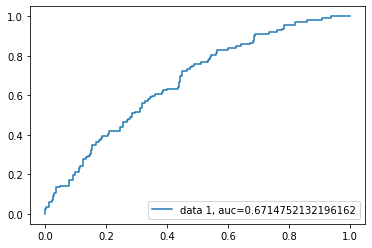

AUC: 0.671


In [48]:
y_pred_proba = logreg.predict_proba(X_test_pca50)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

**10 Principal Components**


**Define and Run the Model**

In [49]:
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_pca10, y_train)

y_pred = logreg.predict(X_test_pca10)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Model Evaluation Using Confusion Matrix**

In [50]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[261,   7],
       [108,   4]])

The confusion matrix generated above is in the form of an array. Diagnosal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. The diagonal starting with the top left to the bottom right hand corner are actual predidictions, while the bottom left corner to the top right corner are incorrect predictions. 

In [51]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))

Accuracy: 0.697
Recall: 0.036
Precision: 0.364


**ROC**

The Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. 

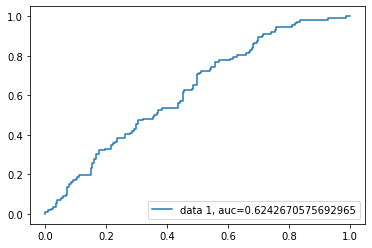

AUC: 0.624


In [52]:
y_pred_proba = logreg.predict_proba(X_test_pca10)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

**Clinical Data**


**Define and Run the Model**

In [56]:
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Model Evaluation Using Confusion Matrix**

In [57]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[237,  31],
       [ 79,  33]])

The confusion matrix generated above is in the form of an array. Diagnosal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. The diagonal starting with the top left to the bottom right hand corner are actual predidictions, while the bottom left corner to the top right corner are incorrect predictions. 

In [58]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))

Accuracy: 0.711
Recall: 0.295
Precision: 0.516


**ROC**

The Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. 

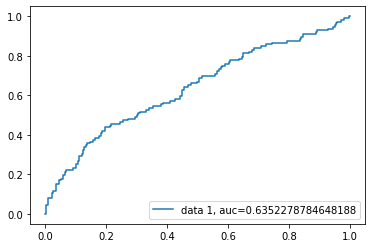

AUC: 0.635


In [59]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

**Clinical Data + 50 Prinicipal Components**


**Define and Run the Model**

In [60]:
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_clinical_pca50, y_train)

y_pred = logreg.predict(X_test_clinical_pca50)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Model Evaluation Using Confusion Matrix**

In [61]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[236,  32],
       [ 73,  39]])

The confusion matrix generated above is in the form of an array. Diagnosal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. The diagonal starting with the top left to the bottom right hand corner are actual predidictions, while the bottom left corner to the top right corner are incorrect predictions. 

In [62]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))

Accuracy: 0.724
Recall: 0.348
Precision: 0.549


**ROC**

The Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. 

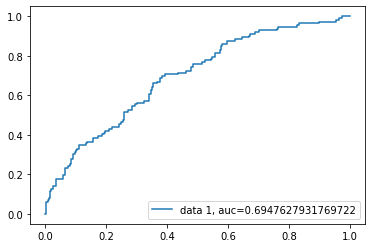

AUC: 0.695


In [63]:
y_pred_proba = logreg.predict_proba(X_test_clinical_pca50)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

**Clinical Data + 10 Prinicipal Components**


**Define and Run the Model**

In [64]:
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_clinical_pca10, y_train)

y_pred = logreg.predict(X_test_clinical_pca10)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Model Evaluation Using Confusion Matrix**

In [65]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[232,  36],
       [ 76,  36]])

The confusion matrix generated above is in the form of an array. Diagnosal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. The diagonal starting with the top left to the bottom right hand corner are actual predidictions, while the bottom left corner to the top right corner are incorrect predictions. 

In [66]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))

Accuracy: 0.705
Recall: 0.321
Precision: 0.5


**ROC**

The Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. 

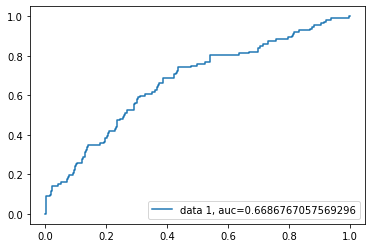

AUC: 0.669


In [67]:
y_pred_proba = logreg.predict_proba(X_test_clinical_pca10)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

In [0]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))

# **Random Forest Classification**

# **Next Steps**



1.   We will assess logistic regression, random forests, and neural networks using 62 and 10 prinicpal components
2.   We will assess clinical variables using logistic regression, random forests, and neural networks
3.   We will assess logistic regression, random forets, and neural networks using prinicpal components and clinical data

